In [77]:
import multiannealing
from glob import glob
from copy import deepcopy
import dill
import time
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

from multiannealing.score.ChemLiabilities import ChemLiabilities
from multiannealing.score.TepitopesMatrix import TepitopesMatrix
from multiannealing.score.EVHmodel import EVHmodel
from multiannealing.score.MultiScore import MultiScore
from multiannealing.score.Basic import TargetSeqEffect, SeqDist
from multiannealing.anneal.MultiAnnealer import MultiAnnealer

# Input

In [78]:
IdeS = '''
VTSVWTKGVTPPANFTQGEDVFHAPYVANQGWYDITKTFNGKDDLLCGAATAG
NMLHWWFDQNKDQIKRYLEEHPEKQKINFNGEQMFDVKEAIDTKNHQLDSKLF
EYFKEKAFPYLSTKHLGVFPDHVIDMFINGYRLSLTNHGPTPVKEGSKDPRGG
IFDAVFTRGDQSKLLTSRHDFKEKNLKEISDLIKKELTEGKALGLSHTYANVR
INHVINLWGADFDSNGNLKAIYVTDSDSNASIGMKKYFVGVNSAGKVAISAKE
IKEDNIGAQVLGLFTLSTGQDSWNQTN
'''.replace('\n','').upper()

In [80]:
JOBID = 'IdeS_48-391_demo'
PDBNAME = 'data/2AU1.pdb'

job_data = {
    'jobid' : JOBID,
    'target_seq' : IdeS,
    'index1' : 48,
    'pdbfile' : PDBNAME
}

# Load models

In [82]:
scorefxn_files = [
 '../../data/netmhciipan/IdeS_48-391_demo_netMHCIIpan_EL.dill',
 '../../data/netmhciipan/IdeS_48-391_demo_netMHCIIpan_BA.dill',
 '../../data/cliab/IdeS_48-391_demo_2AU1_chem_liabilities.dill',
 '../../data/evcouplings/Q9F1R7_STRPY_48-391_b0.60_msc70_mcc50.dill',
]

scorefxns = {}
for fn in scorefxn_files:
    with open(fn, 'rb') as f:
        k = fn.split('/')[-1].replace('.dill','')
        k = k.replace(f'{JOBID}_','')
        k = k.replace(f'Q9F1R7_STRPY_48-391_','')
        if 'evcouplings' in fn:
            k = f'evh_{k}'
        
        scorefxns[k] = dill.load(f)
        
print(list(scorefxns.keys()))

['netMHCIIpan_EL', 'netMHCIIpan_BA', '2AU1_chem_liabilities', 'evh_b0.60_msc70_mcc50']


## Inspection

In [83]:
tepi_EL = scorefxns['netMHCIIpan_EL']
tepi_BA = scorefxns['netMHCIIpan_BA']
wt_tepi = pd.DataFrame(
    [tepi_EL.epitope_scores_P_wt, tepi_BA.epitope_scores_P_wt],
    index=['EL','BA']).T

filt = wt_tepi[wt_tepi.EL.ge(0.10) | wt_tepi.BA.ge(0.20)]
plt.scatter(wt_tepi.loc['DRB1']['BA'], wt_tepi.loc['DRB1']['EL'])
plt.scatter(filt.loc['DRB1']['BA'], filt.loc['DRB1']['EL'])
for pos, row in filt.loc['DRB1'].iterrows():
    plt.text(row['BA'], row['EL'], pos)

plt.gca().axhline(0.10, c='k', ls='--')
plt.gca().axvline(0.20, c='k', ls='--')
plt.gca().set_xlabel('Epitope Prob. Binding Affinity')
plt.gca().set_ylabel('Epitope Prob. Eluted Ligand')
filt.loc['DRB1'].T.style.background_gradient(cmap ='Blues',axis=1)

Core_Pos,73,79,80,127,153,155,163,169,177,184,208,255,258,260,281,296,297,306
EL,0.120766,0.120658,0.316698,0.107476,0.108595,0.015601,0.143075,0.127202,0.008407,0.345047,0.139048,0.106116,0.056741,0.052394,0.112531,0.119063,0.148620,0.157581
BA,0.015655,0.001888,0.004599,0.070428,0.196662,0.217833,0.276782,0.072974,0.266982,0.314312,0.013797,0.292430,0.361918,0.249750,0.043608,0.271970,0.496257,0.004031


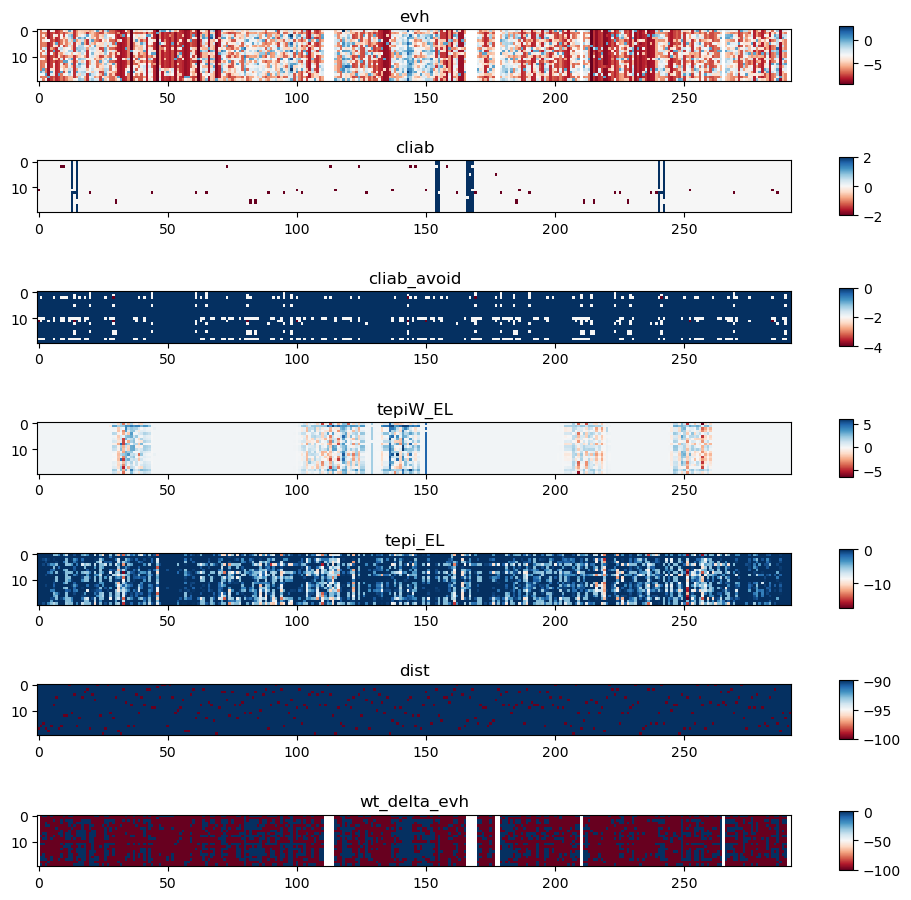

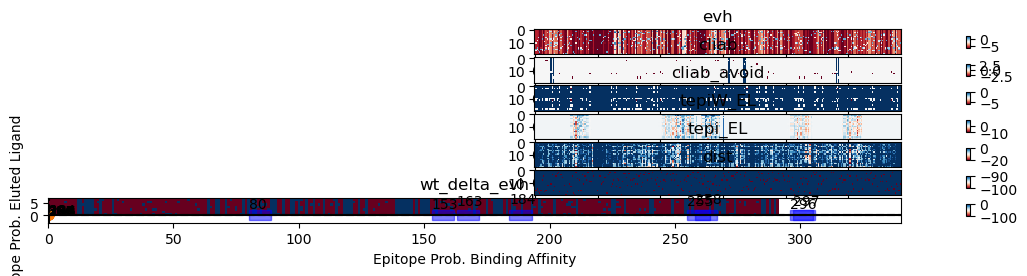

In [84]:
TARGETED_EPITOPES = {184:1.0, 80:1.0, 297:1.0, 163:1.0, 255:1.0, 153:1.0, 258:0.25, 296:0.25}

plt.axhline(0, c='k')
i = 0
for c in TARGETED_EPITOPES.keys():
    rect = patches.Rectangle((c, -2), 9, 4, linewidth=1, edgecolor='b', facecolor='b', alpha=0.5)
    plt.text(c,3+(i%2==0)+(i%3==0),str(c))
    plt.gca().add_patch(rect)
    i += 1
    
plt.gcf().set_size_inches(14,2)
plt.gca().set_ylim(-3,7)
plt.gca().set_xlim(0,340)

plt.show()

# Assemble function

### Interface

In [86]:
INTERFACE_7A = [
    66,67,68,84,85,86,88,90,91,92,93,94,95,96,97,98,127,128,129,
    130,132,133,134,135,155,156,158,159,160,161,162,163,164,165,
    166,167,168,169,170,171,172,173,174,179,184,185,186,187,188,
    189,190,191,192,195,197,198,199,200,201,202,203,204,205,224,
    228,251,252,253,254,255,256,257,258,259,260,261,262,263,264,
    280,282,284,285,286,287,288,290,291,294,295,296,297,301,307,
    308,309,310,311,313,314,315,316,317,318,319,320,321,322,323,
    324,326
]


### Scorefxn - Epitope avoidance

In [88]:
P_INCREASE_CUTOFF = 0.025
P_CEIL_CUTOFF = 0.10

def relu(x,x0=0):
    xc = x-x0
    return xc*(xc>0)

x = np.linspace(0,0.30,100)
f = lambda x: np.minimum(
    (1/(P_CEIL_CUTOFF-P_INCREASE_CUTOFF))*relu(x,P_INCREASE_CUTOFF), 1.0)
y = f(x)

plt.plot(x,y)


In [89]:
WT_P = tepi_EL.predict(tepi_EL.target_seq, tepi_EL.seq_offset, per_epitope=True)
print(WT_P.shape)
P_INCREASE_CUTOFF = 0.025
P_CEILING_CUTOFF = 0.10

def introduced_epitopes(model,seq,i0):
    '''score should penalize increases in probability'''
    # Predict epitope probabilities in target seq
    _ = model.predict_mutscan(seq,i0)
    
    # Current score of seq: penalize where P > WT_P + cutoff
    Pseq_vs_wt_full = model.P_seq_epitopes - WT_P
    Pseq_vs_wt_epi = np.sum(model.gene_weights[:,np.newaxis] * Pseq_vs_wt_full, axis=0)
    score_seq_epi = np.minimum(
        (1/(P_CEILING_CUTOFF-P_INCREASE_CUTOFF))*relu(Pseq_vs_wt_epi,P_INCREASE_CUTOFF),
        1.0)
    score_seq = np.sum(score_seq_epi, axis=0)
    
    # Repeat for single mutations
    ## for each variant [L,AA] vector [genes,epitopes], subtract vs WT vector [genes,epitopes]
    Psmm_vs_wt_full = model.P_smm_epitopes - WT_P[:,:,np.newaxis,np.newaxis]
    # Weight and total by gene, result = [epitopes,L,AA]
    Psmm_vs_wt_epi = np.sum(model.gene_weights[:,np.newaxis,np.newaxis,np.newaxis] * \
                 Psmm_vs_wt_full, axis=0)
    # Increase penalty score if increase > cutoff for ANY epitope
    score_smm_epi = np.minimum(
        (1/(P_CEILING_CUTOFF-P_INCREASE_CUTOFF))*relu(Psmm_vs_wt_epi,P_INCREASE_CUTOFF),
        1.0) # [epitopes,L,AA]
    # Total across epitopes
    score_smm = np.sum(score_smm_epi, axis=0) # [L,AA]
    
    # Delta
    delta_score = score_smm - score_seq
    
    return delta_score

(3, 283)


### Scorefxn - Chemical liab elimination, and avoidance

In [90]:
# we want to avoid creating chem liabilities globally
cliab_model = scorefxns['2AU1_chem_liabilities']
cliab_model.predict_mutscan(job_data['target_seq'], job_data['index1'])
WT_CQAs = cliab_model.x_pred_i
FXN_SITES = np.array([i in (INTERFACE_7A) for i in cliab_model.idx_i])

LIAB_SITES = {}
for k in ['N-glycosylation','RGD','DP_clipping']:
    LIAB_SITES[k] = cliab_model.idx_i
for k in ['deamidation','oxidation','isomerization']:
    LIAB_SITES[k] = FXN_SITES

NO_LIAB = {}
for i,k in enumerate(cliab_model.idx_liabilities):
    NO_LIAB[k] = cliab_model.idx_i[WT_CQAs[i]==0]

    
def eliminate_CQAs(model, seq, i0):
    '''remove liabilities, particularly at functional sites'''
    smm = model.predict_mutscan(seq, i0, include_sites=LIAB_SITES)
    return smm
    
def avoid_CQAs(model, seq, i0):
    '''prevent introduction of any new liabilities'''
    smm = model.predict_mutscan(seq, i0, include_sites=NO_LIAB)
    return smm


In [91]:
A = eliminate_CQAs(cliab_model, job_data['target_seq'], job_data['index1'])
cm = plt.imshow(A.T,
           interpolation='none');
plt.colorbar(cm, shrink=0.2)
plt.gcf().set_size_inches(15,3)

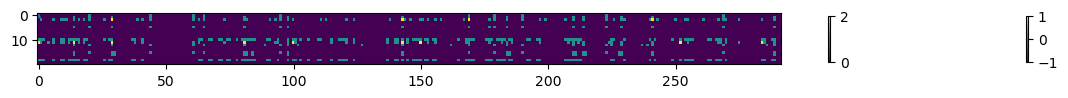

In [92]:
B = avoid_CQAs(cliab_model, job_data['target_seq'], job_data['index1'])
cm = plt.imshow(B.T,
           interpolation='none');
plt.colorbar(cm, shrink=0.2)
plt.gcf().set_size_inches(15,3)
plt.show()

# Simulated annealing run for the bitscore 0.6 model (other models are similar)

In [93]:
EVH_NAME = 'evh_b0.60_msc70_mcc50'
evh_model = scorefxns[EVH_NAME]

evh_p95 = np.percentile(evh_model.predict_mutscan().flatten(),95)
evh_p85 = np.percentile(evh_model.predict_mutscan().flatten(),85)
evh_p66 = np.percentile(evh_model.predict_mutscan().flatten(),66)
evh_p50 = np.percentile(evh_model.predict_mutscan().flatten(),50)

SAFETY_CUTOFF = evh_p66
UTILITY_GAIN = evh_p95 - evh_p85
VIOLATION_PENALTY = evh_p95 - evh_p50

MIN_DIST=10
MAX_DIST=12

print(evh_p95, evh_p85, evh_p50)
print('Safety cutoff', SAFETY_CUTOFF)
print('Approx. value added for desired effects', UTILITY_GAIN)
print('Approx. value penalized for violations', VIOLATION_PENALTY)


def dist_penalty(h, min_dist, max_dist):
    if np.min(h) >= max_dist:  return (h-max_dist)
    if np.max(h) <= min_dist:  return (min_dist-h)
    else:  return h*0
    
def safetynet(model,seq,i0):
    x = model.seq_to_mat(seq,i0)
    score_smm = model.smm <= SAFETY_CUTOFF
    delta_score_smm = score_smm - np.sum(score_smm*x, axis=-1)[:,np.newaxis]
    return delta_score_smm


multi = MultiScore(job_data['target_seq'], job_data['index1'])

# Evolutionary fitness
multi.add_scorefxn(evh_model, 'evh', weight=1)

# Chemical liabilities
multi.add_scorefxn(scorefxns['2AU1_chem_liabilities'], 'cliab', weight=-2,
                   xform = eliminate_CQAs)
multi.add_scorefxn(scorefxns['2AU1_chem_liabilities'], 'cliab_avoid', weight=-2,
                   xform = avoid_CQAs)

# Remove selected T epitopes
scorefxns['netMHCIIpan_EL_W'] = deepcopy(scorefxns['netMHCIIpan_EL'])
scorefxns['netMHCIIpan_EL_W'].set_epitope_weights(TARGETED_EPITOPES)
multi.add_scorefxn(scorefxns['netMHCIIpan_EL_W'], 'tepiW_EL', weight=-20)

# Prevent T epitope gain
multi.add_scorefxn(scorefxns['netMHCIIpan_EL'], 'tepi_EL', weight=-40,
                   xform = introduced_epitopes)

# Specify distance from target sequence
scorefxns['seqdist'] = SeqDist(job_data['target_seq'], job_data['index1'])
multi.add_scorefxn(scorefxns['seqdist'], 'dist', weight=-10,
                   xform=lambda model,seq,io: dist_penalty(
                          model.predict_mutscan(seq,io), MIN_DIST, MAX_DIST))

# Avoid mutations with very low scores in wildtype
evh_model.target_seq = job_data['target_seq']
scorefxns['wt_delta_evh'] = TargetSeqEffect(evh_model)
multi.add_scorefxn(scorefxns['wt_delta_evh'], 'wt_delta_evh',
                   weight=-100, xform=safetynet)

weight_map = {
    'evh': 1,
    'cliab':        -np.around(UTILITY_GAIN/1,0),
    'cliab_avoid':  -np.around(UTILITY_GAIN/1,0),
    'tepiW_EL':     -np.around(UTILITY_GAIN/0.15,0),    # ~ -2 evh : - 0.15 Tepi
    'tepi_EL':      -np.around(VIOLATION_PENALTY/1.0,0), # ~ -5 evh : + >0.10 Tepi
    'dist': -10,
    'wt_delta_evh': -100
}
print('utility boost:  \t', UTILITY_GAIN)
print('violation penalty:\t', VIOLATION_PENALTY)
print(weight_map)

multi.scorefxn_weights = weight_map
multi._precompute_mapping(weight_map=weight_map)

annlr = MultiAnnealer(multi)

0.0 -2.0471692833647483 -5.127437779590764
Safety cutoff -3.678220796179266
Approx. value added for desired effects 2.0471692833647483
Approx. value penalized for violations 5.127437779590764
utility boost:  	 2.0471692833647483
violation penalty:	 5.127437779590764
{'evh': 1, 'cliab': -2.0, 'cliab_avoid': -2.0, 'tepiW_EL': -14.0, 'tepi_EL': -5.0, 'dist': -10, 'wt_delta_evh': -100}
out of 292 target sequence positions
292 / 292  sequence match for model evh
292 / 292  sequence match for model cliab
292 / 292  sequence match for model cliab_avoid
292 / 292  sequence match for model tepiW_EL
292 / 292  sequence match for model tepi_EL
292 / 292  sequence match for model dist
292 / 292  sequence match for model wt_delta_evh


### Looking at mutation options for liability sites:

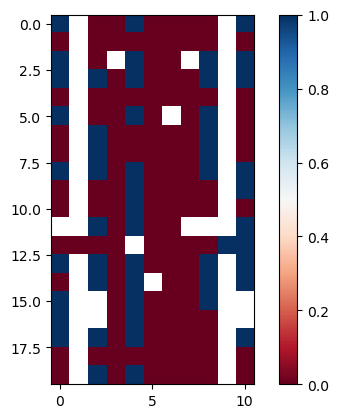

In [94]:
A = multi.aligned_scores[multi.names=='cliab']
B = multi.aligned_scores[multi.names=='evh']
B = deepcopy(1.0*(B > SAFETY_CUTOFF))
B[A>=0] = np.nan

cm = plt.imshow(B[:,np.any(A[0]<0,axis=1),:][0].T, cmap='RdBu')
plt.colorbar(cm);
plt.show()

In [95]:
annlr.visualize_mats()

## Run simulated annealing - for best results, more iterations are recommended

In [96]:
L = len(IdeS)
TCYCLE = [1.0]*int(1.5*L) + [0.5]*int(1.5*L) + [0.10]*int(0.75*L) # CUSTOMIZE Temperature cycle

In [97]:
annlr.Run(TCYCLE)

100%|██████████| 1095/1095 [01:45<00:00, 10.33it/s]


In [98]:
traj = annlr.save_trajectory()

evh
cliab
cliab_avoid
tepiW_EL
tepi_EL
dist
wt_delta_evh


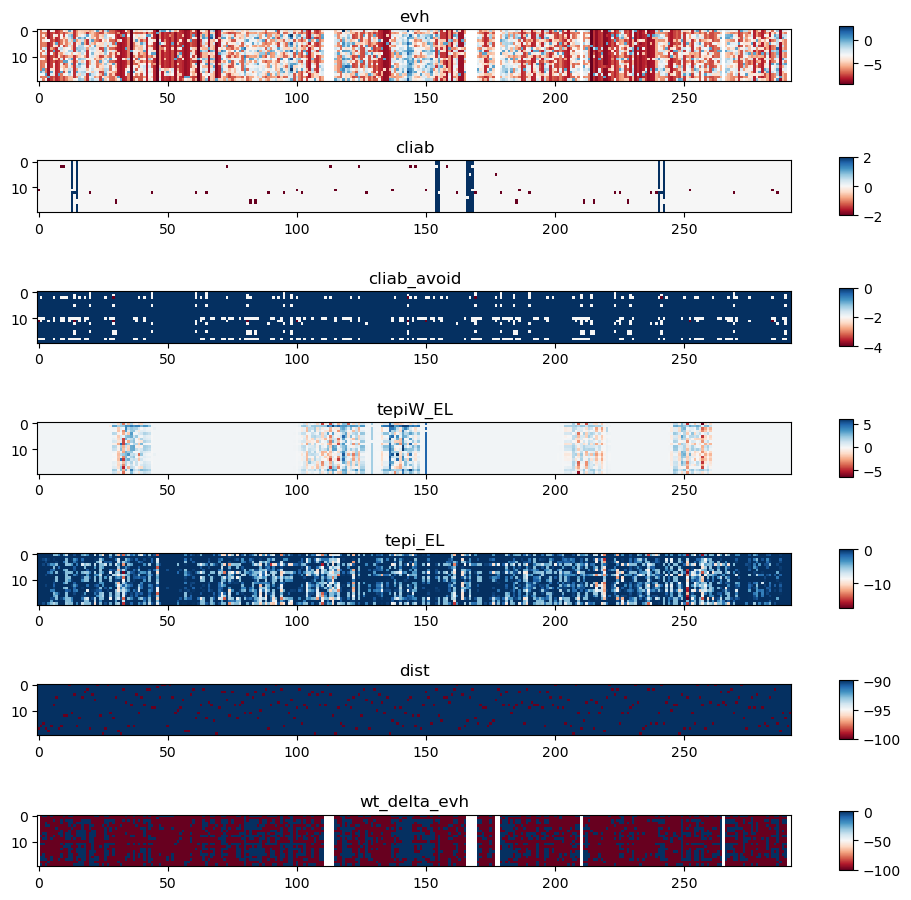

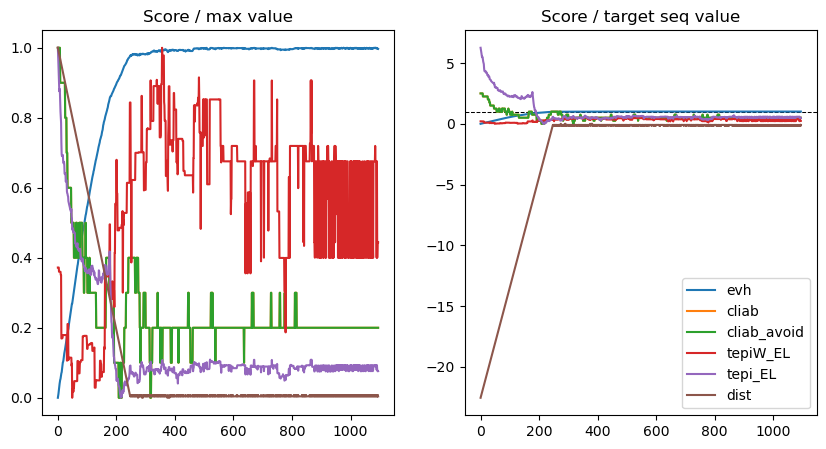

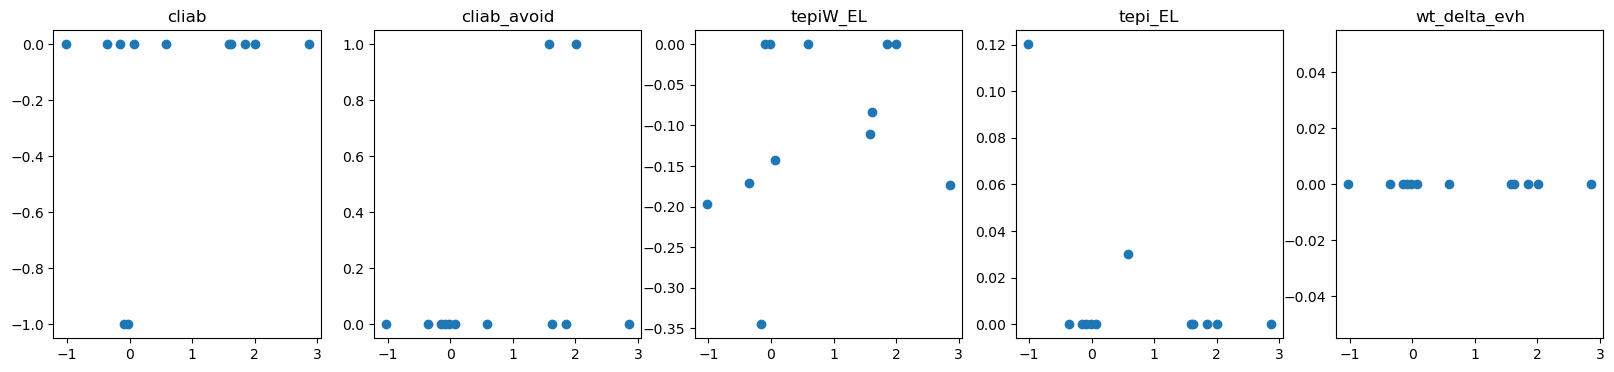

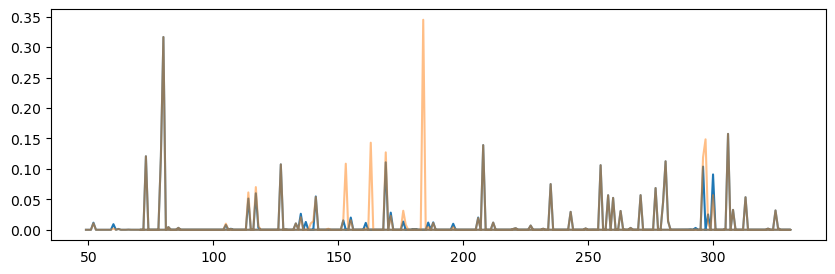

In [99]:
annlr.visualize_design(
    traj.seq.iloc[-1],
    annlr.Score.uniprot_index,
    tepi_name='tepiW_EL',
    #evh_name='evh',
    #dist_name='dist'
)
plt.show()

In [100]:
annlr.traj_df

,mut,seq,P_mut,P_avg,evh,cliab,cliab_avoid,tepiW_EL,tepi_EL,dist
0,R296Y,VYIPVRFIQVWLKVNRGLTTGKCQDWMGYAPLINMGSHGYCGMLMWVSVGFQDWPTCFYNTHNKTYTQRKFAIEWLRQFENNGYDTSGMPEWGDDLSPYRVDVLIFRWPSYKAFPLEFQNMHQDVNQFDERIQKLCWPRDTKLVLATAMPDEHSRWNCNFVFEMMFRGDQLPGKKCCHDLSHQYVEPAQHELMLLDTEGYHVFYFGYHSPVGHTSVWGFHDLACEWKWHQWWCGVCFERPPGQFNKNSYHRLMRRAMHAIAPERTILIWRHEVQCSIEVYWEDHYAFKYQTN,0.943934,0.000171,22.311055,18.0,18.0,0.588767,13.548169,259
1,F252S,VYIPVRFIQVWLKVNRGLTTGKCQDWMGYAPLINMGSHGYCGMLMWVSVGFQDWPTCFYNTHNKTYTQRKFAIEWLRQFENNGYDTSGMPEWGDDLSPYRVDVLIFRWPSYKAFPLEFQNMHQDVNQFDERIQKLCWPRDTKLVLATAMPDEHSRWNCNFVFEMMFRGDQLPGKKCCHDLSHQYVEPAQHELMLLDTEGYHVFYSGYHSPVGHTSVWGFHDLACEWKWHQWWCGVCFERPPGQFNKNSYHRLMRRAMHAIAPERTILIWRHEVQCSIEVYWEDHYAFKYQTN,0.052350,0.000171,28.735494,18.0,18.0,0.588848,13.336883,258
2,F250G,VYIPVRFIQVWLKVNRGLTTGKCQDWMGYAPLINMGSHGYCGMLMWVSVGFQDWPTCFYNTHNKTYTQRKFAIEWLRQFENNGYDTSGMPEWGDDLSPYRVDVLIFRWPSYKAFPLEFQNMHQDVNQFDERIQKLCWPRDTKLVLATAMPDEHSRWNCNFVFEMMFRGDQLPGKKCCHDLSHQYVEPAQHELMLLDTEGYHVGYSGYHSPVGHTSVWGFHDLACEWKWHQWWCGVCFERPPGQFNKNSYHRLMRRAMHAIAPERTILIWRHEVQCSIEVYWEDHYAFKYQTN,0.031501,0.000171,34.992080,18.0,18.0,0.588848,13.091228,257
3,V94C,VYIPVRFIQVWLKVNRGLTTGKCQDWMGYAPLINMGSHGYCGMLMWCSVGFQDWPTCFYNTHNKTYTQRKFAIEWLRQFENNGYDTSGMPEWGDDLSPYRVDVLIFRWPSYKAFPLEFQNMHQDVNQFDERIQKLCWPRDTKLVLATAMPDEHSRWNCNFVFEMMFRGDQLPGKKCCHDLSHQYVEPAQHELMLLDTEGYHVGYSGYHSPVGHTSVWGFHDLACEWKWHQWWCGVCFERPPGQFNKNSYHRLMRRAMHAIAPERTILIWRHEVQCSIEVYWEDHYAFKYQTN,0.527845,0.000171,44.116477,18.0,18.0,0.588848,12.815796,256
4,H267W,VYIPVRFIQVWLKVNRGLTTGKCQDWMGYAPLINMGSHGYCGMLMWCSVGFQDWPTCFYNTHNKTYTQRKFAIEWLRQFENNGYDTSGMPEWGDDLSPYRVDVLIFRWPSYKAFPLEFQNMHQDVNQFDERIQKLCWPRDTKLVLATAMPDEHSRWNCNFVFEMMFRGDQLPGKKCCHDLSHQYVEPAQHELMLLDTEGYHVGYSGYHSPVGHTSVWGFWDLACEWKWHQWWCGVCFERPPGQFNKNSYHRLMRRAMHAIAPERTILIWRHEVQCSIEVYWEDHYAFKYQTN,0.163027,0.000171,52.753704,18.0,18.0,0.580125,12.612386,255
...,...,...,...,...,...,...,...,...,...,...
1090,N297F,VTSVWTKGVTPPAQFTQGEDVFHAPYVANQGWYDITKTFNGKDDLLCGAATAGNMLHWWFDQNKDQIERYLEEHPEKQKINFNGEQMFDVKEAIDTKDNQLDSKLFEYFKEKAFPYLSARRLGVFPDHVLDMFINGYRLSLTKGGPTPVKRGSKDKRGGIFDAVFTRGDQSKLLTSRHDFKEKNLKEISDLIKKELTEGKALGLSHTYANVRINHVINLWGADFDSNGNLKAIYVTDSDSNASIGMKKYFVGVNSAGKVAISAKEIKEDNIGAQVLGLFTLSTGQDSWNQTN,0.662099,0.000171,1168.615167,10.0,10.0,0.806411,5.084544,12
1091,F297N,VTSVWTKGVTPPAQFTQGEDVFHAPYVANQGWYDITKTFNGKDDLLCGAATAGNMLHWWFDQNKDQIERYLEEHPEKQKINFNGEQMFDVKEAIDTKDNQLDSKLFEYFKEKAFPYLSARRLGVFPDHVLDMFINGYRLSLTKGGPTPVKRGSKDKRGGIFDAVFTRGDQSKLLTSRHDFKEKNLKEISDLIKKELTEGKALGLSHTYANVRINHVINLWGADFDSNGNLKAIYVTDSDSNASIGMKKYNVGVNSAGKVAISAKEIKEDNIGAQVLGLFTLSTGQDSWNQTN,0.534344,0.000171,1167.511257,10.0,10.0,0.608978,4.961902,13
1092,R168H,VTSVWTKGVTPPAQFTQGEDVFHAPYVANQGWYDITKTFNGKDDLLCGAATAGNMLHWWFDQNKDQIERYLEEHPEKQKINFNGEQMFDVKEAIDTKDNQLDSKLFEYFKEKAFPYLSARHLGVFPDHVLDMFINGYRLSLTKGGPTPVKRGSKDKRGGIFDAVFTRGDQSKLLTSRHDFKEKNLKEISDLIKKELTEGKALGLSHTYANVRINHVINLWGADFDSNGNLKAIYVTDSDSNASIGMKKYNVGVNSAGKVAISAKEIKEDNIGAQVLGLFTLSTGQDSWNQTN,0.337753,0.000171,1166.153768,10.0,10.0,0.640560,4.927675,12
1093,S200N,VTSVWTKGVTPPAQFTQGEDVFHAPYVANQGWYDITKTFNGKDDLLCGAATAGNMLHWWFDQNKDQIERYLEEHPEKQKINFNGEQMFDVKEAIDTKDNQLDSKLFEYFKEKAFPYLSARHLGVFPDHVLDMFINGYRLSLTKGGPTPVKRGNKDKRGGIFDAVFTRGDQSKLLTSRHDFKEKNLKEISDLIKKELTEGKALGLSHTYANVRINHVINLWGADFDSNGNLKAIYVTDSDSNASIGMKKYNVGVNSAGKVAISAKEIKEDNIGAQVLGLFTLSTGQDSWNQTN,0.018564,0.000171,1166.906601,10.0,10.0,0.640560,4.923956,13
